In [1]:
import numpy as np
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Load the dataset
import pickle

import numpy as np
import matplotlib.pyplot as plt
import random

import scipy.sparse as sp
 
import pickle
from scipy.sparse import csr_matrix

from scipy.sparse import eye
from scipy.sparse.linalg import inv
 

from RelaxRegularize import *



colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from data_loader import *

['political-blog', 'citeseer', 'cora']
political-blog 1222
citeseer 2110
cora 2485


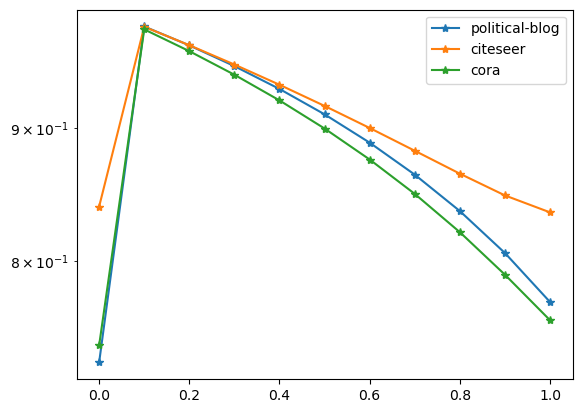

In [2]:

dataset_list = ['political-blog', 'citeseer', 'cora', 'mnist-tr-nei10',
                'pubmed', 'blogcatalog', 'youtube', 'ogbn-arxiv']



dataset_list = ['political-blog', 'citeseer', 'cora', 'blogcatalog',  'mnist-tr-nei10', 'pubmed']
dataset_list = ['political-blog', 'citeseer', 'cora']
def compute_trace_pinv_adjusted(Theta,Y_onehot, betas):
    n = Theta.shape[0]
    
    trace_values = []
    for beta in betas:
        print('\t %f' % beta)
        B = beta * Theta + (1. - beta) * eye(n)
        smooth = ( Y_onehot.T @ (B @ Y_onehot)).diagonal().sum()
   
        Minv = B / (2. * smooth) + eye(n) / (2. * n)
        
        M = inv(Minv)
        trace_values.append(M.diagonal().sum())
    return trace_values



print(dataset_list)

for dataset in dataset_list:
    #print(dataset)
    try:
        betas, trace_values,n = pickle.load(open('regret_bounds/%s_regret.pkl' % dataset,'rb'))
    except:
        trace_values = []
        csr_mat, labels = load_graph_data(dataset)
        n = len(labels)
        
        Theta,nTheta, Y_onehot =  prepare_small_problems(csr_mat,labels)

        trace_values = compute_trace_pinv_adjusted(Theta, Y_onehot,betas = [1])


        betas = np.arange(0.1, 1.1, 0.1)  # Example values of beta
        betas = [0.5,0.9,1.]
        trace_values.extend(compute_trace_pinv_adjusted(nTheta, Y_onehot,betas))
        pickle.dump((betas, trace_values,n), open('regret_bounds/%s_regret.pkl' % dataset,'wb'))
    
    print(dataset, n)
    betas = np.insert(betas,0,0)
    plt.semilogy(betas, np.sqrt(trace_values)/n,marker='*')
 
plt.legend(dataset_list)   
     
    
    


In [3]:
# Solve without coarsening, for baseline results




for dataset in dataset_list:
    
    
    csr_mat, labels = load_graph_data(dataset)
    n = len(labels)
    num_classes = max(labels)+1
    Theta,nTheta, Y_onehot =  prepare_small_problems(csr_mat,labels)
            
    for beta in [0.,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,0.25]:
        
    

        print(dataset,beta)
        try:
            out_relax = pickle.load(open('regret_bounds/%s_beta%f_runrelax.pkl' % (dataset,beta),'rb'))
            out_reg = pickle.load(open('regret_bounds/%s_beta%f_runreg.pkl' % (dataset,beta),'rb'))
        except:


            if beta == 0.:
                T = Theta
                b = 1.
                
            else:
                b = beta 
                T= beta * nTheta + (1. - beta) * eye(n)

            sigma = ( Y_onehot.T @ (T @ Y_onehot)).diagonal().sum()
            
            Delta = num_classes
            
            out_relax = Relaxation(T.toarray(), sigma, Delta, Y_onehot.toarray())
            Y_pred = out_relax['y_pred']
            q = out_relax['q']
            misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))
            out_relax['misclass'] = misclass
            out_relax['Delta'] = Delta
            out_relax['sigma'] = sigma

            out_reg = Regularize(T.toarray(), sigma,  Y_onehot.toarray())
            Y_pred = out_reg['y_pred']
            q = out_reg['q']
            misclass = np.mean(np.sum(Y_pred*(1-Y_onehot.toarray()),axis=1))
            out_reg['misclass'] = misclass
            out_reg['sigma'] = sigma


            pickle.dump(out_relax, open('regret_bounds/%s_beta%f_runrelax.pkl' % (dataset,beta),'wb'))
            pickle.dump(out_reg, open('regret_bounds/%s_beta%f_runreg.pkl' % (dataset,beta),'wb'))

        print(dataset, out_relax['misclass'], out_reg['misclass'])


political-blog 0.0
political-blog 0.06955810147299508 0.19312602291325695
political-blog 0.1
political-blog 0.1751227495908347 0.06873977086743044
political-blog 0.2
political-blog 0.12929623567921442 0.0662847790507365
political-blog 0.3
political-blog 0.1260229132569558 0.0662847790507365
political-blog 0.4
political-blog 0.1260229132569558 0.0662847790507365
political-blog 0.5
political-blog 0.11620294599018004 0.06382978723404255
political-blog 0.6
political-blog 0.09492635024549918 0.0630114566284779
political-blog 0.7
political-blog 0.10965630114566285 0.062193126022913256
political-blog 0.8
political-blog 0.10147299509001637 0.062193126022913256
political-blog 0.9
political-blog 0.09819967266775777 0.0630114566284779
political-blog 1.0
political-blog 0.07692307692307693 0.06137479541734861
political-blog 0.25
political-blog 0.12438625204582651 0.06546644844517185
citeseer 0.0
citeseer 0.33317535545023697 0.25687203791469193
citeseer 0.1
citeseer 0.37203791469194314 0.28862559241

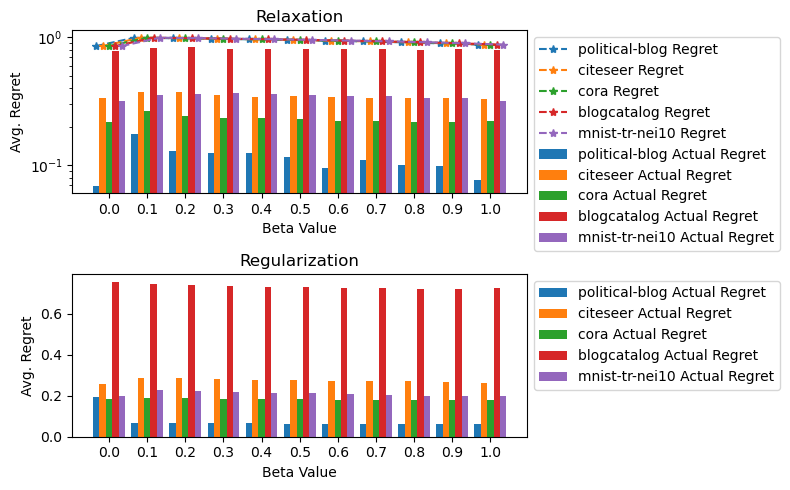

In [4]:

dataset_list = ['political-blog', 'citeseer', 'cora', 'blogcatalog',  'mnist-tr-nei10']

beta_list = [0., .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
misclass = np.zeros((2, len(dataset_list), len(beta_list)))  # 3D array to hold misclassification data


trace_values = [None for d in dataset_list]


for i, dataset in enumerate(dataset_list):
    # Load trace values and n for each dataset
    _, trace_values[i],n = pickle.load(open('regret_bounds/%s_regret.pkl' % dataset,'rb'))     
    trace_values[i] = np.sqrt(trace_values[i])/n
    for b, beta in enumerate(beta_list):
        
        out_relax = pickle.load(open('regret_bounds/%s_beta%f_runrelax.pkl' % (dataset,beta),'rb'))
        out_reg = pickle.load(open('regret_bounds/%s_beta%f_runreg.pkl' % (dataset,beta),'rb'))
        
        
        misclass[0, i, b] = out_relax['misclass']
        misclass[1, i, b] = out_reg['misclass']

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(8, 5))  # Create a figure with two subplots

bar_width = 0.25  # Width of the bars
index = np.arange(len(beta_list)) * 1.5  # Index for the x-axis, scaled to add spacing

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(dataset_list)):
    for j in range(2):
        bar_pos = index + bar_width*i - bar_width*(len(dataset_list)/2 - 0.5)
        ax[j].bar(bar_pos, misclass[j, i, :], bar_width, label=f'{dataset_list[i]} Actual Regret', color=colors[i])
        if j == 0:  # Condition to check if the subplot is "Relaxation"
            ax[j].semilogy(bar_pos, np.sqrt(trace_values[j]), linestyle='--', color=colors[i], marker='*', label=f'{dataset_list[i]} Regret')


ax[0].set_title('Relaxation')
ax[1].set_title('Regularization')


for j in range(2):
    ax[j].set_xlabel('Beta Value')
    ax[j].set_ylabel('Avg. Regret')
    ax[j].set_xticks(index + bar_width/2 - bar_width/2)  # Center the ticks between the bars
    ax[j].set_xticklabels([f'{beta:.1f}' for beta in beta_list])
    ax[j].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot


plt.tight_layout()
    
plt.savefig('small_dataset_baseline.png')
    
   
    
    